# <font color='blue'>ASTR 21100</font>

# <font color='blue'>"Computational Techniques in Astrophysics"</font>

## <font color='blue'>Sampling multi-dimensional distributions with MCMC</font>
## <font color='blue'>Using MCMC in maximum likelihood/Bayesian analysis</font>
    

In [1]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plotting import plot_prettier, plot_2d_dist, plot_color_map
plot_prettier()

## <font color='blue'>Likelihood of data given a linear model</font>


For data vectors $\vec{x}=\{x_i\}$, $\vec{y}=\{y_i\}$ and a linear model $\vec{y}=c + b\vec{x}$ 
in $y$ direction  the likelihood can be written as: 

$$
\mathcal{L}_{\rm m,i}(x_i,y_i\vert c,b,s)=
\frac{1}{\sqrt{2\pi\sigma^2_{\rm tot,i}}}\,\exp\left[-\frac{(y_i-bx_i-c)^2}{2\sigma^2_{\rm tot,i}}\right].
$$

In [2]:
def lngaussian_2d(x, y, points):
    return -0.5*(((x-points[0])/points[2])**2 + ((y-points[1])/points[3])**2)

def plot_linear_like(b=3, c=4, sig=0.1, xlims=[1.,2.5], ylims=[8,12], ng=100, points=None, figsize=4):
    xg = np.linspace(xlims[0], xlims[1], ng)
    yg = np.linspace(ylims[0], ylims[1], ng)
    lgrid = np.zeros((ng,ng))
    for j in range(ng):
        for i in range(ng):
            lgrid[i,j] = -0.5 *  ((yg[i] - b*xg[j] - c)/sig)**2
    if points is not None:
        for j in range(ng):
            for i in range(ng):
                dummy = np.maximum(1e-300,np.exp(lgrid[i,j])+np.exp(lngaussian_2d(xg[j], yg[i], points)))
                lgrid[i,j] = np.log(dummy)
        
    plot_color_map(xg, yg, np.exp(lgrid), xlim=xlims, ylim=ylims, 
                       xlabel = r'$x$', ylabel = '$y$', cmap='Purples', #colorbar=True, 
                       plot_title=r' ', #contours=True, contcmap='cool', 
                       figsize=figsize)    

## <font color='blue'>Model and a data point</font>


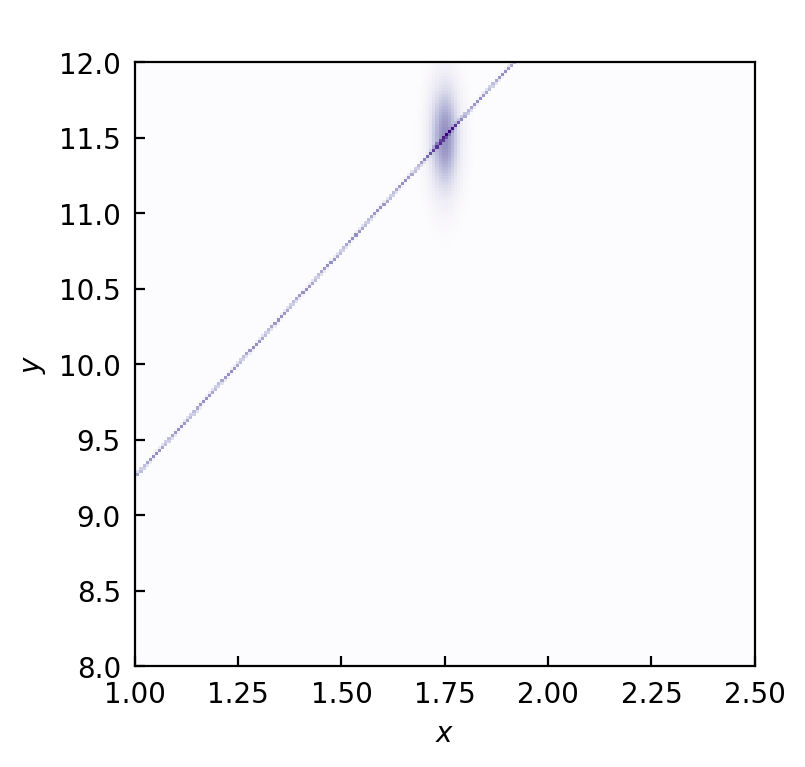

In [104]:
points = [1.75, 11.5, 0.025, 0.25] # x_i, y_i, sig_xi, sig_yi
plot_linear_like(sig=0.01, c=6.25, points=points,ng=200)

The total likelihood for all data points is simply the product of the individual likelihoods (this assumes that measurements are independent): 

$$\mathcal{L}_{\rm m}(\vec{x},\vec{y}\vert c, b, s) = \prod\limits_{i=0}^{N_{\rm data}-1} \mathcal{L}_{\rm m,i}(x_i,y_i\vert c,b,s), $$


$$\ln\mathcal{L}_{\rm m}(\vec{x},\vec{y}\vert c, b, s) = \sum\limits_{i=0}^{N_{\rm data}-1} \ln\mathcal{L}_{\rm m,i}(x_i,y_i\vert c, b, s) = -\frac{1}{2}\,\sum\limits_{i=0}^{N_{\rm data}-1}\left[\ln 2\pi\sigma^2_{\rm tot,i} +\frac{(y_i-bx_i-c)^2}{\sigma^2_{\rm tot,i}}\right]$$


Here

$$
\sigma^2_{\rm tot,i} = \sigma^2_{y_i}+b^2\sigma^2_{x_i},
$$

and $\sigma_{x_i}$ and $\sigma_{y_i}$ are the Gaussian uncertainties of $x_i$ and $y_i$, respectively. Such likelihood is equivalent to using cost function in likelihood maximization that is given by the distance from each measurement to the model line along $y$ axis.


Function below computes $\ln L$ given by expression above for input values of $c$ and $b$ and data set passed through <tt>args</tt>

$$\ln\mathcal{L}_{\rm m}(\vec{x},\vec{y}\vert c, b, s) = \sum\limits_{i=0}^{N_{\rm data}-1} \ln\mathcal{L}_{\rm m,i}(x_i,y_i\vert c, b, s) = -\frac{1}{2}\,\sum\limits_{i=0}^{N_{\rm data}-1}\left[\ln 2\pi\sigma^2_{\rm tot,i} +\frac{(y_i-bx_i-c)^2}{\sigma^2_{\rm tot,i}}\right]$$


In [4]:
# this is ln L_m(c,b,s|x,y)

def loglin_like(p, *args):
    '''
    p[0] = c, p[1] = b, args contains data 
    '''
    c, b = p
    x, y, sigx, sigy = args # data
    sigtot2 = sigy**2 + (b*sigx)**2
    
    # 1/sqrt(2.*pi) factor can be omitted from the likelihood because it does not depend on model parameters
    return np.sum(-0.5 * (np.log(2.*np.pi*sigtot2) + (y - b*x - c)**2 / sigtot2))
    

### <font color='darkblue'>Mock data set for testing the model inference</font>


The functions below generate a mock data set that follows a linear relation with specified slope and intercept (<tt>btrue, ctrue</tt>) and uncertainties in both $x$ and $y$ variables. Given that we know what the true values of $b$ and $c$ are for the mock dataset generated in this way, we can use the data to test the model. 

In [5]:
def generate_mock_data(xlims, ex, ey, btrue=3, ctrue=3.481, nr = 2000):
    xr = np.random.uniform(xlims[0], xlims[1], size=nr) 

    exr = np.random.normal(scale=ex, size=nr)
    eyr = np.random.normal(scale=ey, size=nr)

    yr = btrue * xr + ctrue + eyr
    xr = xr + exr
    
    return xr, exr, yr, eyr

In [6]:
def plot_mock_data(xr, yr, exr=None, eyr=None, 
                   btrue=None, ctrue=None, figsize=(5,5)):
    # plot mock data
    plt.figure(figsize=figsize)
    plt.errorbar(xr, yr, xerr=exr, yerr=eyr, fmt='o', alpha=0.5, color='darkslateblue')
    plt.xlabel(r'x')
    plt.ylabel('y')
    xf = np.linspace(xr.min(), xr.max(), 10)
    plt.plot(xf, btrue * xf + ctrue, '--', c='orangered', label='true model')
    plt.legend(loc='best')
    plt.show()

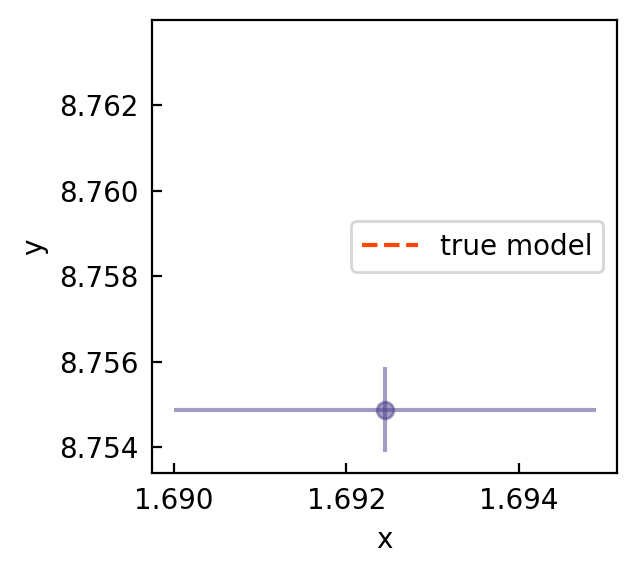

In [105]:
# generate mock data with a given slope and intercept
nr = 1 # number of data points to generate
btrue, ctrue = 3.11, 3.5
ex, ey = 0.001, 0.005
xr, exr, yr, eyr = generate_mock_data([0.7, 2.5], ex, ey, btrue=btrue, ctrue=ctrue, nr=nr)

plot_mock_data(xr, yr, exr=exr, eyr=eyr, btrue=btrue, ctrue=ctrue, figsize=(3,3))

In [106]:
def mcmc_simple(x0, nsteps, step, logpdf, *args):
    """
    a simple implementation of the Metropolis MCMC algorithm
    implements steps using a uniformly distributed random number in the range [-step,step]

    Parameters:
    -----------
    x0:     1d numpy array of floats (size = number of dimensions), initial point
    nsteps: integer, the number of steps to make
    step:   float, step size normalization
    logpdf: Python function object for the ln(pdf) function
    args:   list, a list of arguments to pass to logpdf (can be empty)
    
    Returns:
    --------
    chain: list of size nsteps, containing all recorded steps 
    """
    x = x0 
    nparams = np.size(x0) # dimensionality of distribution we are sampling
    fnow = logpdf(x, *args) # compute current value of ln(pdf)
    
    chain = [] # initialize chain list
    for nstep in range(nsteps):
        xtry = x + step * np.random.uniform(-1, 1., size=nparams)
        ftry = logpdf(xtry, *args)
        if ftry > fnow:
            x = xtry
            fnow = ftry
        else: 
            u = np.random.uniform()
            if np.log(u) < ftry - fnow:
                x = xtry
                fnow = ftry
                
        chain.append(x)
        
    return chain

In [108]:
ndim = 1
nsteps = 50000
x0 = [3.5, 3.] # start at the true values of the parameters
step = 0.1

args = [xr, yr, exr, eyr]
chain = np.asarray(mcmc_simple(x0, nsteps, step, loglin_like, *args))

Plot parameter values sampled in the MCMC chain in the $c-b$ plane as 2D histogram. The contours are defined by the values in the list <tt>conflevs</tt>, which are chosen to encose $68.27\%$ and $95.45\%$ of samples, which approximately corresponds to $1-\sigma$ and $2-\sigma$ of the 1D Gaussian pdf. Such contours are referred to as $1-\sigma$ and $2-\sigma$ contours. 

The true values of the slope and intercept are shown by red cross. We get unbiased values of the parameters if the sampled likelihood pdf is within these contours. If  regenerate the mock data set again and again and redo the sampling each time, we should see that the true value should be within $1\sigma$ contour about $68.25\%$ of the time (try this!). 

C:\Users\akrav\Documents\Classes\a211s22\codes\plotting.py:327: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls),


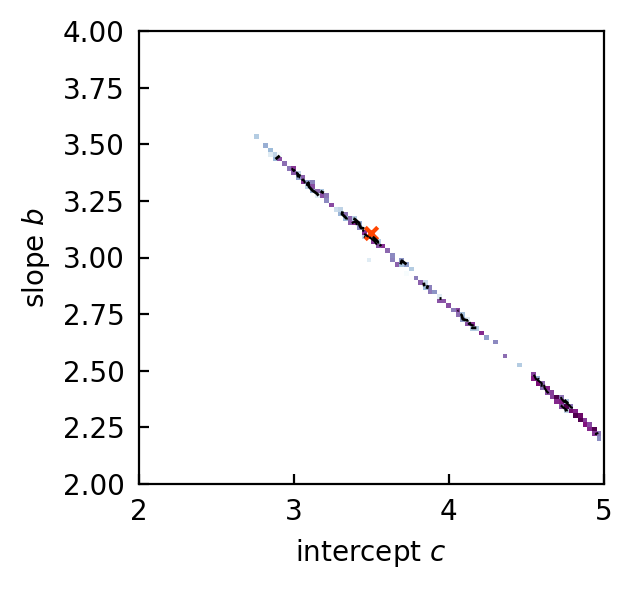

In [109]:
conflevs = [0.6827, 0.9545]

plot_2d_dist(chain[:,0], chain[:,1], xlim=[2,5], ylim =[2.,4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

In [50]:
def c_lims(a):
    '''
    compute confidence limits given a given percentile a
    '''
    x1 = 0.5*(100.-a)
    return x1, a + x1

def chain_stats(x, param_name='x'):
    """
    print mean, median, and confidence intervals for samples for a chain of sampled values
    for a *single* parameter
    """
    xmed = np.median(x); xm = np.mean(x); xsd = np.std(x)
    a = 68.268; 
    x1, x2 = c_lims(a)
    xcfl11 = np.percentile(x,x1); xcfl12 = np.percentile(x,x2)
    a = 95.452
    x1, x2 = c_lims(a)
    xcfl21 = np.percentile(x,x1); xcfl22 = np.percentile(x,x2)
    dashedline = '-------'
    print('============ statistics for the {:s} ============'.format(param_name))
    print('mean, median = %.3f, %.3f, st.dev=%.4f'%(xm, xmed, xsd))
    print('68 perc interval = %.3f, %.3f'%(xcfl11, xcfl12))
    print('95 perc interval = %.3f, %.3f'%(xcfl21, xcfl22))


In [107]:
chain_stats(chain[:,0], param_name='intercept')
chain_stats(chain[:,1], param_name='slope')

============ statistics for the intercept ============
mean, median = 3.502, 3.507, st.dev=0.0863
68 perc interval = 3.411, 3.594
95 perc interval = 3.331, 3.668
============ statistics for the slope ============
mean, median = 3.097, 3.095, st.dev=0.0410
68 perc interval = 3.054, 3.140
95 perc interval = 3.016, 3.175


In [11]:
def get_ln_loglike_grid(ng=100, clims=[2.,5.], blims=[2.,4.], args=[]):
    cg = np.linspace(clims[0], clims[1], ng)
    bg = np.linspace(blims[0], blims[1], ng)

    loglike = np.zeros((ng,ng))
    for i in range(ng): 
        for j in range(ng): 
            loglike[j,i] = loglin_like(np.array([cg[i],bg[j]]), *args)
    return cg, bg, loglike

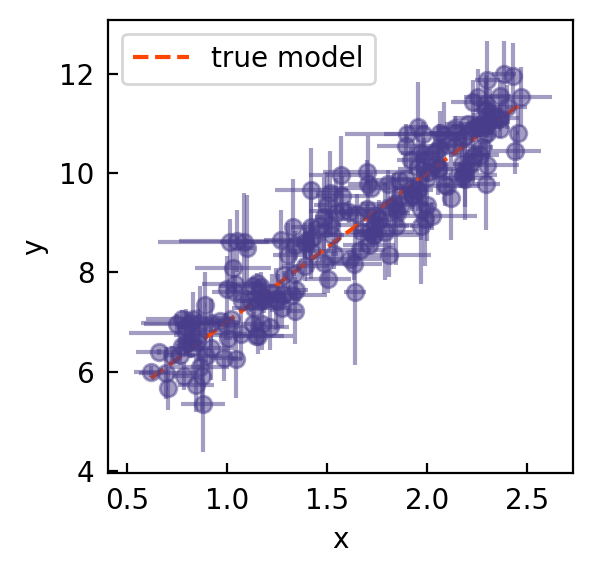

In [119]:
# generate mock data with a given slope and intercept
nr = 200 # number of data points to generate
btrue, ctrue = 3, 4
ex, ey = 0.1, 0.5
xr, exr, yr, eyr = generate_mock_data([0.7, 2.5], ex, ey, btrue=btrue, ctrue=ctrue, nr=nr)

plot_mock_data(xr, yr, exr=exr, eyr=eyr, btrue=btrue, ctrue=ctrue, figsize=(3,3))

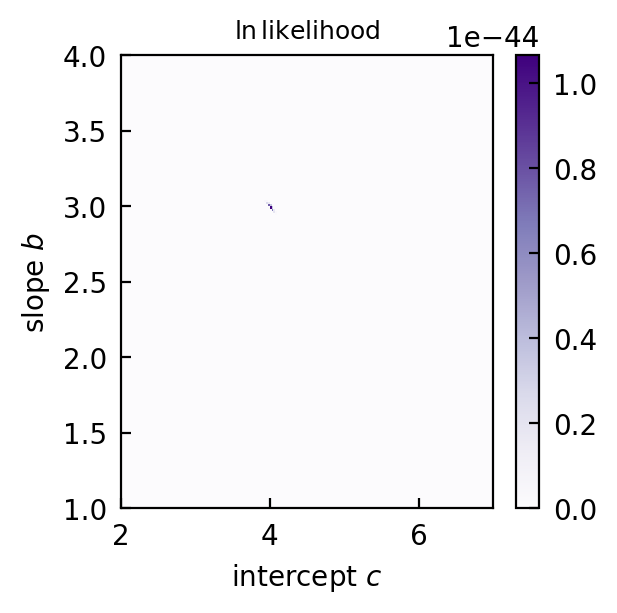

In [120]:
conflevs = [1-0.6827, 1-0.9545, 1-0.9973]
clims, blims = [2.,7], [1,4.]
args = [xr, yr, exr, eyr]

cg, bg, loglike = get_ln_loglike_grid(ng=200, clims=clims, blims=blims, args=args)
plot_color_map(cg, bg, np.exp(loglike), xlim=clims, ylim=blims, 
                   xlabel = r'intercept $c$', ylabel = 'slope $b$', cmap='Purples', colorbar=True, 
                   plot_title=r'$\rm \ln likelihood $', #contours=True, contcmap='cool', 
                   levels = conflevs[::-1], figsize=3.0)

### <font color='darkblue'>Importance of the starting point and burn-in

You may have noticed that the MCMC sampling above was started at the true values of the parameters. 
This is the luxury we may not have. 
    
Recalculation below shows what happens when we start at values pretty far from the true ones. 

In [57]:
# generate mock data with a given slope and intercept
nr = 50 # number of data points to generate
btrue, ctrue = 3.11, 3.5
ex, ey = 0.1, 0.5
xr, exr, yr, eyr = generate_mock_data([0.7, 2.5], ex, ey, btrue=btrue, ctrue=ctrue, nr=nr)

# run MCMC
ndim = 2
nsteps = 100000
x0 = [0, 1.] # start at the true values of the parameters
step = 0.1

args = [xr, yr, exr, eyr]
chain = np.asarray(mcmc_simple(x0, nsteps, step, loglin_like, *args))

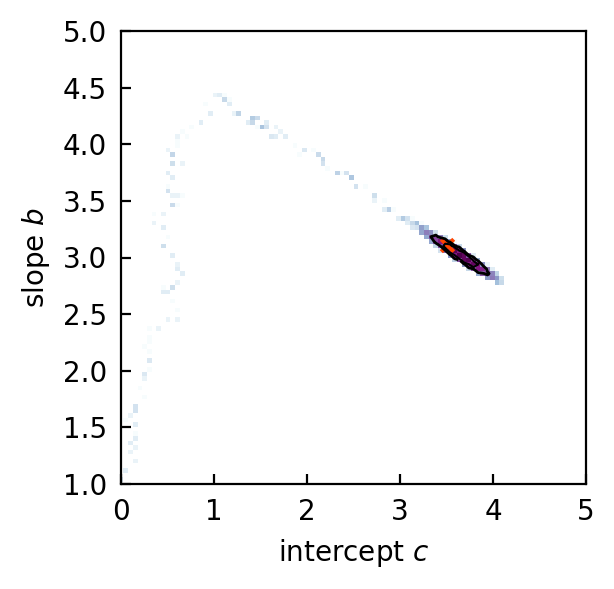

In [58]:
conflevs = [0.6827, 0.9545]

plot_2d_dist(chain[:,0], chain[:,1], xlim=[0,5], ylim =[1.,5], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

We can see that the chain recovers, but there is a fairly sizeable initial portion of the chain where samples do not follow the Gaussian pdf. This is the "burn-in" part of the chain. If it is not removed, it can potentially bias our estimates of quantities such as mean values of parameters. 

Burn-in can be minimized if we start from the initial values of parameters that are close to the maximum of the distribution. Thus, it helps to know where this maximum is. Finding extrema of functions is handled by ***optimization methods***, which we discussed, and as was shown above.

Here is an example using SciPy's differential evolution function. Here we define minus log likelihood  because we will use function that finds minimum to find maximum:

In [121]:
def minus_loglin_like(x, *args):
    '''
    define minus log likelihood because we will use function that finds minimum to find maximum
    '''
    return -loglin_like(x, *args)

In [122]:
from scipy.optimize import differential_evolution

args = [xr, yr, exr, eyr]
bounds = [[1,5],[1,5]]

res = differential_evolution(minus_loglin_like, bounds=bounds, args=args)

print(f'The best fit intercept and slope values: c = {res.x[0]:.3f}, b = {res.x[1]:.3f}')

The best fit intercept and slope values: c = 4.013, b = 2.993


This illustrates that just knowing the values that maximize likelihood is not particularly meaningful: intecept and slope are not exactly equal to their true values, but we don't know whether this means that our inference is wrong or is this because these values are uncertain due to uncertainties in the data. To answer this question we need to estimate confidence limits on the parameters as was shown above. 

## <font color='darkblue'>Bayesian approach</font>
    
Bayesian approach is based on 
**the Bayes theorem**:

$$p({\rm model\vert data})=\frac{L({\rm data}\vert {\rm model})\,p({\rm model})}{p({\rm data})}$$


which, in turn, is a consequence of the usual chain rule of joint probability of data and model: 

$$p({\rm data,\ model}) = p({\rm model}\vert {\rm data})\,p({\rm data}) = L({\rm data}\vert {\rm model})\,p({\rm model})$$

As mentioned before, the probability of data given the model $p({\rm data}\vert {\rm model})$ is usually called ***the likelihood*** in statistical analyses: 

$$L({\rm data}\vert {\rm model}) := p({\rm data}\vert {\rm model})$$


So Bayesian approach differs from the maximum likelihood method by multiplication of the likelihood by the prior pdf's of model parameters. 


###  <font color='darkblue'>Note:
    
When dealing with conditional probabilities, it's useful to remember that
probability distributions have dimensions to make sure that they are used correctly. A given pdf measures *density* of probability per length of the interval, so $p(x)$ has dimension of $x^{-1}$ so that $p(x)dx$ is dimensionless and gives probability of $x$ to be in $[x,x+dx]$. Likewise, $p(x,y)$ has dimensions of $x^{-1}y^{-1}$.

Conditional pdf notation may be a bit confusing in this regard, but the key is that dimensionality of pdf only depends on the variables to the left of $\vert$, so $p(x|y)$ has dimension $x^{-1}$, $p(x,y|z)$ has dimensions $x^{-1}y^{-1}$ etc. 
    
It's useful to remember this, because then it can be used to check expressions involving probability. 
Thus, for example, $\int p(x|y)dx$ is a dimensionless probability, if $p$ is a properly normalized pdf, while $\int p(x|y)dy$ is not because it has dimensions of $[y/x]$.

The Bayes theorem reflects dimensionalities of the pdfs that enter into its expression. For example:

$$p(x|y) = \frac{p(y|x)p(x)}{p(y)}.$$

If we compute dimensions of pdf on the left and expression on the right hand side, they will both have dimension of $x^{-1}$. 

***Prior pdf:***
As the prior pdf for the linear model we will use distribution that assumes uniform distribution of angle of the line of the linear model wrt $x$-axis (i.e. uniform distribution of $\tan b$) and distribution of $c$ that is uniform and invariant to rotation of the coordinate axes, as discussed above:

$$p(c,b,s)=\frac{1}{2\pi(c_{\rm max}-c_{\rm min})(s_{\rm max}-s_{\rm min})}\,\frac{1}{(1+b^2)^{3/2}},$$


###  <font color='darkblue'>Prior distributions for the linear model


If we have good reasons to think that slope and intercept should be within a given range, then priors corresponding to that range should be defined. However, if we don't really know what values to expect, then prior distributions can be inferred via the following considerations. 

 Slope $b$ varies from zero to infinity, and uniform prior in $b$ would thus assign a lot of probability to large $b$ values, which can bias inferred $m$ values high. Most natural assumption is thus that angle formed by the line and say $x$ axis is uniformly distributed  $\alpha\in[-\pi/2,\pi/2]$, where $b=\tan\alpha$. Differential $db=d\alpha/\cos^2\alpha=d\alpha(1+b^2)$. Thus, uniform prior on $\alpha$ implies 
 
$$p(\alpha)d\alpha={\rm const}\ \ \ \rightarrow\ \ \ \ p(b)\propto \frac{db}{1+b^2}.$$
 
A somewhat trickier, but not overly complicated consideration (see your notebook) also suggests that the prior pdf of $c$ should be 

$$p(c)\propto \frac{1}{\sqrt{1+b^2}},$$

so that 

$$p(c,b)\propto \frac{1}{(1+b^2)^{3/2}}.$$

**Note:** it is natural to assume uniform prior not in $c$, because $c$ depends on the particular choice of axis $y$, which will change if reference frame is rotated, but distance from the line to the origin $(x,y)=(0,0)$, $c_\perp=c\cos\alpha=c/\sqrt{1+b^2}$, which is invariant to rotation of the frame. Then $dc_\perp = dc/\sqrt{1+b^2}$ and uniform prior in $dc_\perp$ implies 

$$p(c)\propto \frac{1}{\sqrt{1+b^2}},$$

so that 

$$p(c,b)\propto \frac{1}{(1+b^2)^{3/2}}.$$

This prior can also be formally derived by requiring that $p(c,b)$ functional form is symmetric to switch of $x$ and $y$ axes. Prior pdfs above are expressed as proportionalities without normalization constants. These constants do not matter for MCMC sampling because it is not sensitive to the constant normalization of the sample distribution. 


### <font color='darkblue'>Posterior pdf
    
In the Bayesian approach instead of finding the maximum of and sampling the likelihood function we sample the posterior pdf given by the product of the likelihood function and prior pdfs of parameters. 
    
Thus, for the linear model posterior pdf is:
    
$$\pi(b,c\vert \vec{d}) = L(\vec{d}\vert b,c) p(b)p(c).$$
    
where $\vec{d}$ includes all data $\vec{d}=\{\vec{x},\vec{y},\vec{\sigma}_x,\vec{\sigma}_y\}$. 
    
$$\ln \pi(b,c\vert \vec{d}) = \ln L(\vec{d}\vert b,c) + \ln p(b) + \ln p(c).$$
    
    
As for likelihood, for numerical stability we sample $\ln\pi$ instead of $\pi$:

$$\ln \pi(b,c\vert \vec{d}) = n\ln{1\over \sqrt{2\pi}}  - {1\over 2} \,\sum\limits_{i=0}^{n-1}\ln\sigma_{i}^2-{1\over 2} \,\sum\limits_{i=0}^{n-1}\left(\frac{r_i}{\sigma_{i}}\right)^2 + \ln p(b) + \ln p(c),$$

The constant factor $n\ln{1/\sqrt{2\pi}}$ is not important for MCMC sampling itself, which is not sensitive to constant normalization factors, but it is important for estimating Bayesian evidence or BIC criterion described below. 

## <font color='darkblue'>Example: linear model with intrinsic scatter</font>
    
## <font color='darkblue'>Testing Modified Newtonian Dynamica (MOND) model using Baryonic Tully-Fisher relation and Bayesian statistics


**Background.** Galaxies are large collections of gas and stars. Interstellar gas and stars in the "spiral" (aka "disk") galaxies like our Milky Way or [NGC 6384 galaxy](http://astrodvorek.cz/Pics/N6384_1n.jpg) rotates around the center with a velocity that is correlated with the total mass, $M$, of gas and stars in that galaxy. This relation is called the ["Tully-Fisher relation" (TFR)](https://en.wikipedia.org/wiki/Tully%E2%80%93Fisher_relation) in honor of the two astronomers, Brent Tully and Richard Fisher, who discovered it in 1977.   Our Sun, for example, is moving on a nearly circular orbit around the center of the Milky Way with the "***rotation velocity***" of $\approx 220$ km/sec. 

The relation can be approximated by the "power-law form": $M=a v_{\rm rot}^b.$ Such form becomes linear for the logarithms of the mass and rotation velocity: 

$$\log_{10} M = b\log_{10} v_{\rm rot} + \log_{10}a = b\log_{10} v_{\rm rot} + c,$$

and thus we can measure the slope $b$ and "*intercept*" $c$ of this relation using measurements for a sample of galaxies. 

In [66]:
from astropy.io import fits

url = 'http://astro.uchicago.edu/~andrey/classes/a205/data/bradford16_fig1.fits'
b16 = fits.getdata(url)

# width of the HI 21 cm line = proxy for rotation velocity in km/s
vrot = b16['VW20I']; 
# error of W20b
evrot = b16['VW20I_ERR']
# log of Vrot
x = np.log10(vrot)
# approximate log error
ex = 0.5*(np.log10(vrot+evrot) - np.log10(np.maximum(vrot-evrot,1.e-10)))

# log10 of the gas mass and star mass (aka the "baryons")
y = b16['MBARYON']; 
# error of log10(gas+stars mass)
ey = b16['MBARYON_ERR']

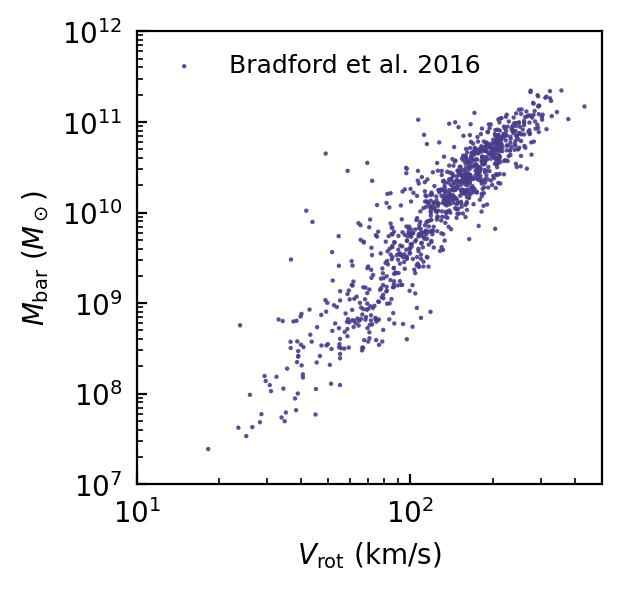

In [21]:
plt.figure(figsize=(3.,3.))
plt.xscale('log'); plt.yscale('log')
plt.xlim([10.,500.]); plt.ylim([1.e7,1.e12]) 
plt.xlabel(r'$V_{\rm rot}\rm\ (km/s)$'); plt.ylabel(r'$M_{\rm bar}\ (M_\odot)$')
plt.scatter(vrot, 10.**y,marker='.',c='darkslateblue',s=10.,alpha=0.9,edgecolor='none', label='Bradford et al. 2016')

plt.legend(frameon=False,loc='upper left', fontsize=9)
plt.show()

Examining the plot above, you should notice that there is an overall trend that can be described by a linear relation, but there is also quite a bit of scatter.   This scatter can be due to measurement errors of $\log_{10}M_{\rm bar}$ and $\log_{10}V_{\rm rot}$. However, it is also possible that there is *intrinsic* scatter - i.e. real physical scatter of galaxies in the plane of $\log_{10}M_{\rm bar}-\log_{10}V_{\rm rot}$ around average linear region, which would be useful to constrain (if it's small) or measure.     
    
To this end, we will introduce an additional parameter in the linear model  - *intrinsic* scatter, $s$, around average linear trend. 

For data vectors $\vec{x}=\{x_i\}$, $\vec{y}=\{y_i\}$ and a linear model $\vec{y}=c + b\vec{x}$ with intrinsic Gaussian scatter in $y$ direction  the likelihood can be written as (see, for example, <a href="http://adsabs.harvard.edu/abs/2005physics..11182D">D'Agostini 2005</a>): 

$$
\mathcal{L}_{\rm m,i}(x_i,y_i,\sigma_{x_i}, \sigma_{y_i}\vert c,b,s)=
\frac{1}{\sqrt{2\pi\sigma^2_{\rm tot,i}}}\,\exp\left[-\frac{(y_i-bx_i-c)^2}{2\sigma^2_{\rm tot,i}}\right].
$$

where

$$
\sigma^2_{\rm tot,i} = s^2+\sigma^2_{y_i}+b^2\sigma^2_{x_i},
$$

and $\sigma_{x_i}$ and $\sigma_{y_i}$ are the Gaussian uncertainties of $x_i$ and $y_i$, respectively. Such likelihood is equivalent to using cost function in likelihood maximization that is given by the distance from each measurement to the model line along $y$ axis.

The total likelihood for all data points is simply the product of the individual likelihoods (this assumes that measurements are independent): 

$$\mathcal{L}_{\rm m}(\vec{x},\vec{y}, \vec{\sigma}_x,\vec{\sigma}_y\vert c, b, s) = \prod\limits_{i=0}^{N_{\rm data}-1} \mathcal{L}_{\rm m,i} $$

Here we will use Bayes theorem to estimate the intercept, $c$, slope, $m$, and intrinsic scatter $s$ of a linear model for $\log_{10} M_{\rm bar}-\log_{10} V_{\rm rot}$ for the   <a href="http://adsabs.harvard.edu/abs/2016ApJ...832...11B">Bradford et al. (2016)</a> sample.

***Prior pdf:***
As the prior pdf for this model we will use distribution that assumes uniform distribution of angle of the line of the linear model wrt $x$-axis (i.e. uniform distribution of $\tan b$) and distribution of $c$ that is uniform and invariant to rotation of the coordinate axes, as discussed above:

$$p(c,b,s)=\frac{1}{2\pi(c_{\rm max}-c_{\rm min})(s_{\rm max}-s_{\rm min})}\,\frac{1}{(1+b^2)^{3/2}},$$


In [61]:
cmin = 2.5; cmax = 4.5 # flat prior range on normalization
smin = 0.1; smax = 0.4 # flat prior range on scatter

normfact = 0.5 / np.pi/ (cmax - cmin) / (smax - smin)

def prior(xd):
    """
    defines parameter priors
    
    Parameters
    ----------
    xd : numpy 1d array
        xd[0] = normalization; xd[1] = slope; xd[2] = scatter
        
    Returns
    -------
    numpy float
        ln(prior)
        
    """
    if cmin <= xd[0] and xd[0] < cmax and smin <= xd[2] and xd[2] < smax:
        return np.log(normfact/(1. + xd[1]**2)**1.5)
    else:
        return -300.



In [62]:
def linmodel_likelihood(p, *args):
    """
    ln of linear model likelihood

    Parameters:
    -----------
    p - real 1d numpy vector of size 3 
        values of the model parameters, c, m, intrinsic scatter in y direction
    x - real 1d numpy vector
        x values of data, array size = number of data points ndata
    sigx2 - real 1d numpy vector of size x
        Gaussian variances of x
    y - real 1d numpy vector
        y values of data of the same size as x 
    sigy2 - real 1d numpy vector of size 
        Gaussian variances of y
    sigxy - real 1d numpy vector of size 
        Gaussian covariances of x and y    

    Returns:
    --------

    a real number 
        ln(Likelihood of linear model with intrinsic Gaussian scatter in y direction)
    """
    x, sigx2, y, sigy2 = args
    sigtot2 = sigy2  + p[1]**2*sigx2 + p[2]**2
    # this step is not to allow sigtot2 to become negative which will make np.log of it below a nan (Not A Number)
    sigtot2 = np.maximum(sigtot2, 1.6e-16)
    
    # 1/sqrt(2.*pi) factor can be omitted from the likelihood because it does not depend on model parameters
    return np.sum(-0.5 * (np.log(sigtot2) + (y - p[0] - p[1]*x)**2 / sigtot2))
    

In [63]:
  
def lnlinmodel_posterior(p, x, sigx2, y, sigy2):
    """
    -ln of unnormalized posterior of the linear model 
    p - real 1d numpy vector of size 3 
        values of the model parameters, c, m, intrinsic scatter in y direction
    x - real 1d numpy vector
        x values of data, array size = number of data points ndata
    sigx2 - real 1d numpy vector of size x
        Gaussian variances of x
    y - real 1d numpy vector
        y values of data of the same size as x 
    sigy2 - real 1d numpy vector of size 
        Gaussian variances of y
    sigxy - real 1d numpy vector of size 
        Gaussian covariances of x and y    
    Returns:
    --------

    a real number 
        ln(Likelihood of linear model with intrinsic Gaussian scatter in y direction)
    """
    return linmodel_likelihood(p, x, sigx2, y, sigy2) + prior(p)
    

In [64]:
def lnlinposterior_min(p, *args):
    return -lnlinmodel_posterior(p, *args) 

In [67]:
from scipy.optimize import minimize

x0 = [3.5, 3., 0.2]
resl = minimize(lnlinposterior_min, x0, method='Nelder-Mead', 
               args=(x, ex**2, y, ey**2), options={'xtol': 1e-10, 'disp': True})
print("minimum at :",resl.x)


Optimization terminated successfully.
         Current function value: -590.046875
         Iterations: 142
         Function evaluations: 284
minimum at : [3.51530958 3.09042727 0.25278398]


Given that there are only 3 parameters, we can use 3D grid to sample values of the product of the likelihood and priors around the best fit parameters above. For larger number of parameters, we would need to use a more sophisticated method or MCMC sampling to sample this product. 

In [68]:
ndim = 3 # the model has 3 parameters 
nsteps = 100000 # number of MCMC steps
step = 0.1 # max step size (steps are random in [-step,step])

# pass data as arguments to the posterior pdf
args = [x, ex**2, y, ey**2]
# initialize at the best fit parameters
x0 = resl.x

chain = np.asarray(mcmc_simple(x0, nsteps, step, lnlinmodel_posterior, *args))

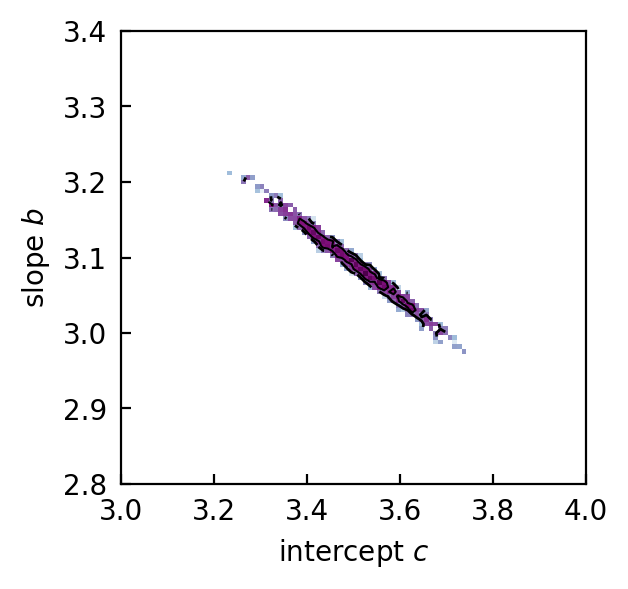

In [69]:
conflevs = [0.6827, 0.9545]

plot_2d_dist(chain[:,0], chain[:,1], xlim=[3.,4], ylim =[2.8,3.4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

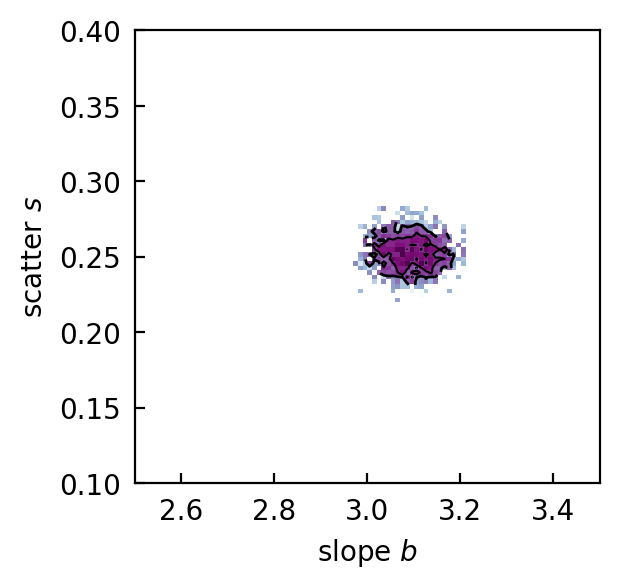

In [70]:
plot_2d_dist(chain[:,1], chain[:,2], xlim=[2.5,3.5], ylim =[0.1,0.4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             ylabel=r'${\rm scatter}\ s$', 
             xlabel=r'${\rm slope}\ b$', figsize=(3,3))

In [31]:
def clims(a):
    x1 = 0.5*(100.-a)
    return x1, a + x1

def chain_stats(x, param_name='x'):
    """
    print mean, median, and confidence intervals for samples for a chain of sampled values
    for a *single* parameter
    """
    xmed = np.median(x); xm = np.mean(x); xsd = np.std(x)
    a = 68.268; 
    x1, x2 = clims(a)
    xcfl11 = np.percentile(x,x1); xcfl12 = np.percentile(x,x2)
    a = 95.452
    x1, x2 = clims(a)
    xcfl21 = np.percentile(x,x1); xcfl22 = np.percentile(x,x2)
    dashedline = '-------'
    print('============ statistics for {:s} ============'.format(param_name))
    print('mean, median = %.3f, %.3f, st.dev=%.4f'%(xm, xmed, xsd))
    print('68 perc interval = %.3f, %.3f'%(xcfl11, xcfl12))
    print('95 perc interval = %.3f, %.3f'%(xcfl21, xcfl22))


In [71]:
chain_stats(chain[:,0], param_name='intercept')
chain_stats(chain[:,1], param_name='slope')
chain_stats(chain[:,2], param_name='scatter')

============ statistics for the intercept ============
mean, median = 3.502, 3.507, st.dev=0.0863
68 perc interval = 3.411, 3.594
95 perc interval = 3.331, 3.668
============ statistics for the slope ============
mean, median = 3.097, 3.095, st.dev=0.0410
68 perc interval = 3.054, 3.140
95 perc interval = 3.016, 3.175
============ statistics for the scatter ============
mean, median = 0.254, 0.254, st.dev=0.0081
68 perc interval = 0.246, 0.262
95 perc interval = 0.238, 0.270


The MOND model is excuded by this data in the context of this linear model. 

To fully carry this test fully requires exploring other types of linear models. We tested only one type of linear model with Gaussian scatter along y direction. We can also think about model with Gaussian scatter in the direction perpendicular to the line. This will give a somewhat larger slope, but still <4 with high significance. 

However, how certain are we in the statistical results above? Has the chain converged? Are the derived parameters and their uncertainties reliable? How many independent samples do we have in the chain?

In [74]:
def plot_trace(x, figsize=3):
    try:
        nsteps, ndims = np.shape(x)[0], np.shape(x)[1]
    except:
        nsteps, ndims = np.shape(x)[0], 1
        
    plt.figure(figsize=(figsize,figsize))
    for d in range(ndims):
        if ndims == 1:
            plt.plot(np.arange(0,nsteps,1), x, lw=0.5, c='darkslateblue', label='d={:d}'.format(d))
        else:
            plt.plot(np.arange(0,nsteps), x[:,d], lw=0.5, c='darkslateblue', label='d={:d}'.format(d))
    plt.ylabel(r'$x$') # label axis 
    plt.xlabel(r'step number')
    plt.show()    

The first plot above shows that the slope and intercept are *linearly (anti) correlated* and correlation is very strong. We see also that the contours are poorly sampled despite many steps taken by MCMC. This is because with such large degeneracy, most random steps of size 0.1 are in the directions of very small likelihood values and so are rejected. The chain in this case has a large fraction of duplicate positions. 

Here is how it can be estimated. 

In [72]:
# step acceptance fraction
acc_frac = np.unique(chain).size/chain.size 
print(f'acceptance fraction = {acc_frac:.4f}')

acceptance fraction = 0.0120


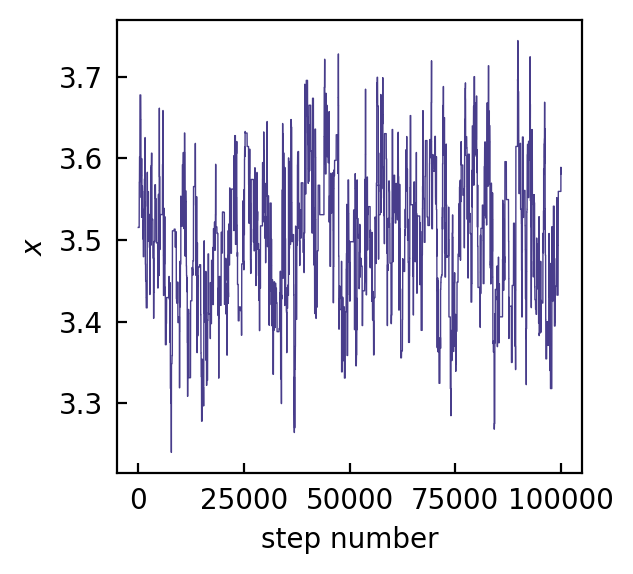

In [75]:
plot_trace(chain[:,0])

#### Pivoting

There is a relatively simple trick called **pivoting** that can help to largely remove the degeneracy, which will help MCMC sampling and increase accepted step fraction. 

Pivoting is simply shifting $x$ and $y$ of the data by their averages: $x^\prime = x -\bar{x}$, $y^\prime=y-\bar{y}$ and then use these pivoted $x^\prime$ and $y^\prime$ to infer the parameters. In the end, the intercept will need to be converted back to the original value, while slope is not affected by the shift, because it just moves all data points by constant value. 

Below is illustration for how this works. 

###  <font color='blue'>Sampling using GW10 MCMC algorithm implemented in the emcee MCMC package</font>

A better sampling method, such as the affine-invariant method of Goodman & Weare (2010). Below is an example of how it works using its implementation in the <a href="https://emcee.readthedocs.io/en/v2.2.1/"><tt>emcee</tt></a> package. You can find installation instructions [here](https://emcee.readthedocs.io/en/v2.2.1/user/install/).  

In [278]:
# pass data as arguments to the posterior pdf
# no pivoting here
args = [x, ex**2, y, ey**2]
# initialize at the best fit parameters


In [279]:
import emcee

ndim, nwalkers, nsteps = 3, 50, 10000

# initialize walkers around best fit parameter values
p0 = np.zeros(((nwalkers, ndim)))
for d in range(ndim): 
    # generate Gaussian random numbers and shift the mean to the best fit values
    # 0.05 is a small dispersion around the mean. The exact value does not matter
    p0[:,d] = resl.x[d] + 0.05*np.random.normal(size=nwalkers)
    
# create an instance of the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim,  lnlinmodel_posterior, args=args)

# run for a given nsteps
dummy = sampler.run_mcmc(p0, nsteps)

# get chain
chain = np.array(sampler.chain)

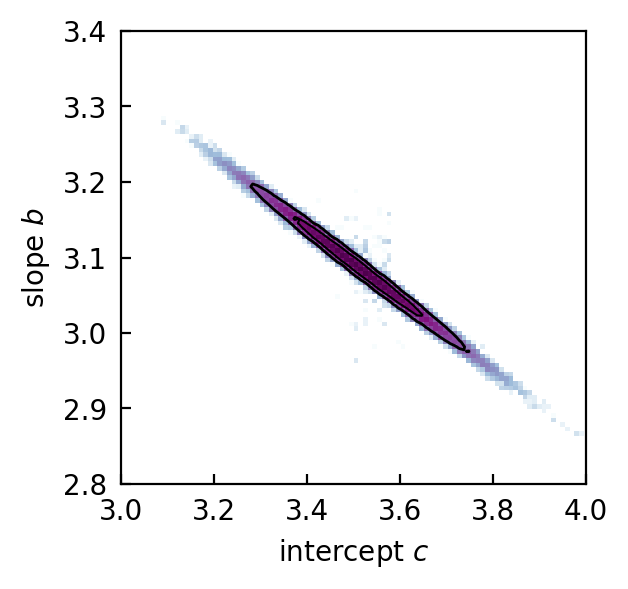

In [281]:
conflevs = [0.6827, 0.9545]

c = chain[:,:,0].flatten()
b = chain[:,:,1].flatten()
s = chain[:,:,2].flatten()


plot_2d_dist(c, b, xlim=[3, 4], ylim =[2.8,3.4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

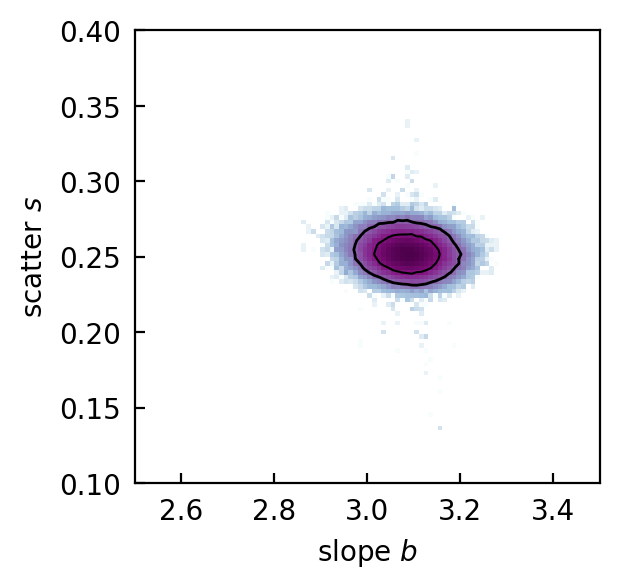

In [282]:
plot_2d_dist(b, s, xlim=[2.5,3.5], ylim =[0.1,0.4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             ylabel=r'${\rm scatter}\ s$', 
             xlabel=r'${\rm slope}\ b$', figsize=(3,3))

We can see that the distribution is much better sampled, which is due to a much larger acceptance fraction. The large fraction of steps in this algorithm is because steps are taken along directions to other samples, so as samples arange along the degeneracy line of $b$ and $c$ most steps are along that line, not away from it as most steps in the standard MCMC would have. So most steps in the GW10 algorithm are in high probability areas. 

In [283]:
# step acceptance fraction
acc_frac = np.unique(c).size/c.size 
print(f'acceptance fraction = {acc_frac:.4f}')

acceptance fraction = 0.6461


The trace plot now looks very much like a hairy caterpillar, as shown below. We have to be careful here, because we need to look at the trace of individual "walkers". 

In [284]:
# take first 10 walkers and combine them into chain 100000 long
x = np.empty(0)
for i in range(10):
    x = np.hstack((x,chain[i,:,0]))

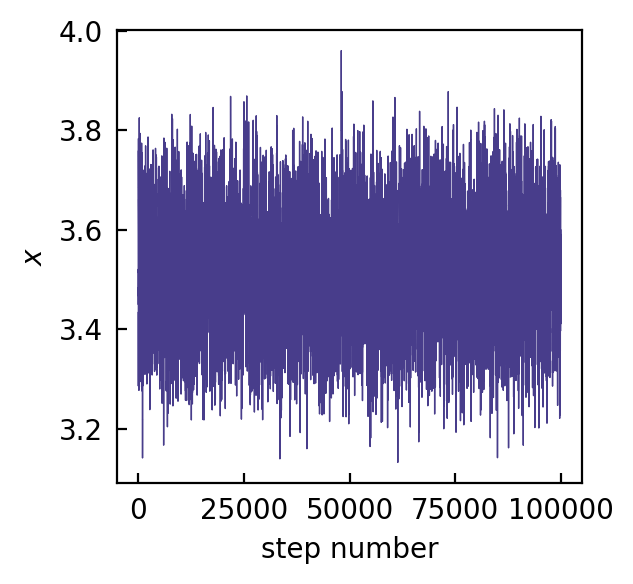

In [285]:
plot_trace(x)

In [286]:
def clims(a):
    x1 = 0.5*(100.-a)
    return x1, a + x1

def chain_stats(x, param_name='x'):
    """
    print mean, median, and confidence intervals for samples for a chain of sampled values
    for a *single* parameter
    """
    xmed = np.median(x); xm = np.mean(x); xsd = np.std(x)
    a = 68.268; 
    x1, x2 = clims(a)
    xcfl11 = np.percentile(x,x1); xcfl12 = np.percentile(x,x2)
    a = 95.452
    x1, x2 = clims(a)
    xcfl21 = np.percentile(x,x1); xcfl22 = np.percentile(x,x2)
    dashedline = '-------'
    print('============ statistics for {:s} ============'.format(param_name))
    print('mean, median = %.3f, %.3f, st.dev=%.4f'%(xm, xmed, xsd))
    print('68 perc interval = %.3f, %.3f'%(xcfl11, xcfl12))
    print('95 perc interval = %.3f, %.3f'%(xcfl21, xcfl22))


In [287]:
chain_stats(c, param_name='intercept')
chain_stats(b, param_name='slope')
chain_stats(s, param_name='scatter')

============ statistics for intercept ============
mean, median = 3.514, 3.514, st.dev=0.0961
68 perc interval = 3.419, 3.610
95 perc interval = 3.323, 3.707
============ statistics for slope ============
mean, median = 3.091, 3.091, st.dev=0.0457
68 perc interval = 3.045, 3.137
95 perc interval = 2.999, 3.182
============ statistics for scatter ============
mean, median = 0.254, 0.254, st.dev=0.0084
68 perc interval = 0.245, 0.262
95 perc interval = 0.237, 0.271


###  <font color='blue'>Constraints on matter and dark energy density using supernovae type Ia</font>


In this example, supernovae type Ia are assumed to be perfect standard candles, so that their $M_0$ is exactly the same for all supernovae. In this case, the model has only 3 parameters: $\Omega_{\rm m0}$, $\Omega_\Lambda$, $\tilde{M}$, instead of 5 as in homework 5. Nevertheless everything else is similar. 

In [77]:
#zCMB, mB, emB are redshift of SNia, its apparent B-band magnitude, and emB is its error
# x1 and ex1 are stretch parameter measured for each SN and its uncertainty
# csn and ecsn are color parameter and its uncertainty
zCMB, mB, emB, x1, ex1, csn, ecsn = np.loadtxt('https://astro.uchicago.edu/~andrey/classes/a211/data/jla_lcparams.txt', 
                                               usecols=(1, 4, 5, 6, 7, 8, 9), unpack=True)

print("read sample of %d supernovae..."%(np.size(zCMB)))

read sample of 740 supernovae...


Note that the function below uses <a href="https://www.astropy.org/">Astropy</a> to compute $d_L$ values for a given cosmological model parameters and supernova redshifts rather than approximation as in homework 5.

In [189]:
from astropy.cosmology import LambdaCDM
import astropy.units as u
clight = 2.99792458e5 # c in km/s
H0c = 70. / clight

def d_l_astropy(z, Om0, OmL):
    # instantiate cosmological model class 
    cosmo = LambdaCDM(H0=70, Om0=Om0, Ode0=OmL) 
    # use luminosity_distance method to compute d_L for z values for this cosmo model
    return cosmo.luminosity_distance(z=z) / u.Mpc * H0c

Define the function to minimize $=-\ln L$.

In [216]:
def priors(x):
    '''
    implementation of simple uniform prior pdfs for all parameters
    
    normalization of the pdfs does not matter for sampling so the uniform pdfs are assumed
    to simply have amplitude of 1 (so ln(1)=0) or exp(-100000) - this is an approximation for 0 (or log = -100000)
    '''
    # if parameters are outside the range of values defined by their prior pdfs return ln(0) 
    # approximated by -100000
    if (x[0]<0.) or (x[0]>1) or (x[1] < 0.) or (x[1] > 1.) or (x[2] < 20.) or (x[2] > 28.):
        return -100000.
    #otherwise return ln(1) = 0 
    return 0

def lnlike(x, *args):
    '''
    ln Likelihood
    '''
    zsn, msn, emsn, nsn = args
    dlsn = d_l_astropy(zsn, x[0], x[1])
    musn_model = 5.*np.log10(dlsn)

    return -0.5*np.sum(((msn - (musn_model + x[2]))/emsn)**2)

def lnpost(x, *args): 
    '''
    ln posterior pdf p(Om0,OmL,Mtilde|data) = p(data|Om0,OmL,Mtilde) * p(Om0,OmL,Mtilde)
    '''
    p = priors(x)

    if p == 0.:
        return lnlike(x, *args)
    else:
        return p

In [217]:
def minus_lnpost(x, *args):
    return -lnpost(x, *args)

In [218]:
from scipy.optimize import minimize

x0 = np.array([0.1, 0.11, 22.])

res = minimize(minus_lnpost, x0, method='nelder-mead', args=(zCMB, mB, emB, zCMB.size), tol=1.e-14)

print("minimum at :",res.x)

minimum at : [ 0.37478174  0.32217776 24.10834292]


In [227]:
import emcee
from time import time

ndim, nwalkers, nsteps = 3, 50, 10000

# initialize walkers around best fit parameter values
p0 = np.zeros(((nwalkers, ndim)))
for d in range(ndim): 
    # generate Gaussian random numbers and shift the mean to the best fit values
    # 0.05 is a small dispersion around the mean. The exact value does not matter
    p0[:,d] = res.x[d] + 0.05*np.random.normal(size=nwalkers)
    
# create an instance of the MCMC sampler
args=(zCMB, mB, emB, zCMB.size)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=args)

t0 = time()
# run for a given nsteps
dummy = sampler.run_mcmc(p0, nsteps, progress=True)
print(f'sampling completed in {time()-t0:.2f} sec')

# get chain
chain = np.array(sampler.chain)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:37<00:00, 17.31it/s]

sampling completed in 577.84 sec


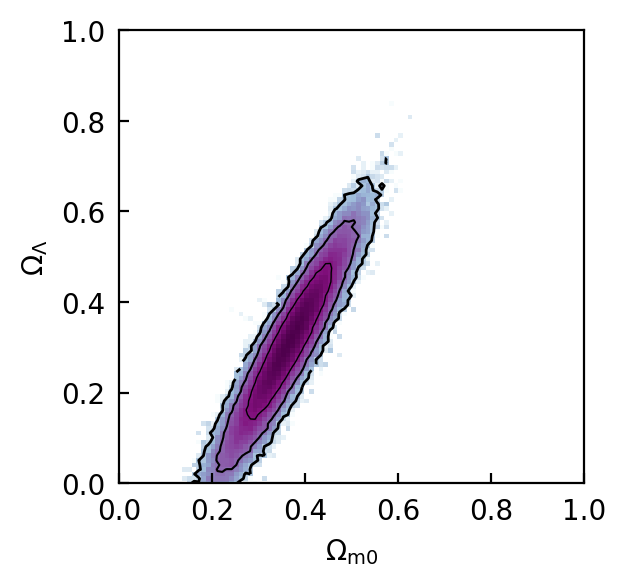

In [228]:
conflevs = [0.6827, 0.9545, 0.9973]

om0 = chain[:,:,0].flatten()
oml = chain[:,:,1].flatten()
Mt = chain[:,:,2].flatten()


plot_2d_dist(om0, oml, xlim=[0, 1], ylim =[0,1], 
             nxbins=100, nybins=100, 
             clevs=conflevs, 
             xlabel=r'$\Omega_{\rm m0}$', 
             ylabel=r'$\Omega_\Lambda$', figsize=(3,3))

### Recommended reading

* S 3.1-3.8 and S 2 of the <a href="http://adsabs.harvard.edu/abs/2017ARA%26A..55..213S">ARA&A review</a> by Sanjib Sharma on MCMC methods for Bayesian data analysis in astronomy.

